In [476]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import random

from analysis import *
import evaluation_data_definitions as edd

import nltk

In [477]:
surge_annotations_comparative

0  \
bot            bot comp       label       dialogues                                              
rerank_blender blender2_3B    consistent  ((1055,38)_rerank_blender, (1055,38)_blender2_3B) -1   
                              grammatical ((1055,38)_rerank_blender, (1055,38)_blender2_3B)  0   
                              engaging    ((1055,38)_rerank_blender, (1055,38)_blender2_3B)  1   
                              quality     ((1055,38)_rerank_blender, (1055,38)_blender2_3B) -1   
                              proactive   ((1055,38)_rerank_blender, (1055,38)_blender2_3B)  1   
...                                                                                         ..   
blender2_3B    rerank_blender quality     ((438,26)_blender2_3B, (438,26)_rerank_blender)   -1   
                              engaging    ((438,26)_blender2_3B, (438,26)_rerank_blender)   -1   
                              proactive   ((438,26)_blender2_3B, (438,26)_rerank_blender)   -1   
                              consistent  ((438,26)_blender2_3B, (438,26)_rerank_blender)    1   
                              emotional   ((438,26)_blender2_3B, (438,26)_rerank_blender)   -1   

                                                                                               1  
bot            bot comp       label       dialogues                                               
rerank_blender blender2_3B    consistent  ((1055,38)_rerank_blender, (1055,38)_blender2_3B) -1.0  
                              grammatical ((1055,38)_rerank_blender, (1055,38)_blender2_3B) -1.0  
                              engaging    ((1055,38)_rerank_blender, (1055,38)_blender2_3B) -1.0  
                              quality     ((1055,38)_rerank_blender, (1055,38)_blender2_3B) -1.0  
                              proactive   ((1055,38)_rerank_blender, (1055,38)_blender2_3B)  1.0  
...                                                                                          ...  
blender2_3B    rerank_blender quality     ((438,26)_blender2_3B, (438,26)_rerank_blender)    NaN  
                              engaging    ((438,26)_blender2_3B, (438,26)_rerank_blender)    NaN  
                              proactive   ((438,26)_blender2_3B, (438,26)_rerank_blender)    NaN  
                              consistent  ((438,26)_blender2_3B, (438,26)_rerank_blender)    NaN  
                              emotional   ((438,26)_blender2_3B, (438,26)_rerank_blender)    NaN  

[3232 rows x 2 columns]

In [478]:
def to_file(f):
    def fn_to_file(*args, load=None, reload=None, **kwargs):
        if load:
            return pd.read_csv(load)
        result = f(*args, **kwargs)
        if reload:
            result.to_csv(reload)
        return result
    return fn_to_file

In [479]:
def prettify(df, float_prec=None, col_types=None, sort_by=None, to_csv=None, index=True, header=True):
    if col_types:
        for col, type in col_types.items():
            df[col] = df[col].astype(type)
    if sort_by:
        df.sort_values(sort_by, ascending=False, inplace=True)
    if float_prec:
        df = df.round(float_prec)
    if to_csv:
        df.to_csv(to_csv, float_format=f"%.{float_prec}f", header=header, index=index)
    return df

In [480]:
@to_file
def across_evaluations(annotations, evaluation_fn):
    """
    :param annotations: iterable of annotations df to apply evaluation_fn to
    :param evaluation_fn: function (input is annotations df, output is results df)
    :return: results dataframe where first index level codes which evaluation (integer id)
    """
    results = [evaluation_fn(annotation) for annotation in annotations]
    all_results = pd.concat(results, keys=range(len(results)))
    all_results.index.set_names('round', level=0, inplace=True)
    return all_results

# 3 Behavior Evaluation Procedure

### Behavior Examples

In [481]:
def get_example(
        evaluation,
        category,
        label,
        mark,
        bot=None,
        context=0,
        seed=123,
        annotations: pd.DataFrame = None
):
    if annotations is None:
        annotations = evaluation.annotation_dataframe()
    labels = annotations.xs((category, label), level=(1, 2)).reset_index()
    options = labels[labels[0] == mark]
    if bot:
        options = options[options[sym.bot] == bot]
    try:
        example = options.sample(1, random_state=seed)
    except ValueError:
        return f'No samples for {category} {label} {mark} {bot}\n'
    eid = example[sym.item].item()
    if isinstance(eid, tuple):
        did, tid = eid
        turns = evaluation.dialogues[did].turns[max(0, tid-context):tid+1]
        botstring = '' if not bot else f'{bot}~~~\n'
        contextstring = ''.join((
            (
                f'User:  {turn.user_turn}\n'
                f'Sys:   {turn.bot_turn}\n'
            )
            for turn in turns[:-1]
        ))
        turn = turns[-1]
        turnstring = (
            f'User:  {turn.user_turn}\n'
            f'Sys:   {turn.bot_turn}\n'
            f'Label: {label} = {mark}\n'
        )
        return botstring + contextstring + turnstring
    else:
        dialogue = evaluation.dialogues[eid]
        turns = [
            turn
            for turn_pair in dialogue.turns
            for turn in (turn_pair.user_turn, turn_pair.bot_turn)
        ]
        return '\n'.join([f'{dialogue.bot}~~~', *turns, f'Label: {label} = {mark}\n'])


In [482]:
seeds = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
for s, b in zip(seeds, behavior):
    print(get_example(
        data.surge_evaluation,
        category.behavior, b, context=0, mark=1,
        seed=s,
        annotations=surge_annotations
    ))

User:  Yeah, I guess a lot of them are pretty sad people too just looking for someway to feel something 
Sys:   Yeah, that's what I think too. I think it's because they don't have anything going on in their lives.
Label: antisocial = 1

User:  We met through a dating app. We keep in contact a lot, and it's good conversation.
Sys:   Is that where you met this new person? How long have you been together? It's nice to see happy endings!
Label: commonsense contradiction = 1

User:  I am a student
Sys:   Wow, I don't think I've ever heard of that. What kind of job is it?
Label: partner contradiction = 1

User:  I see, do you have a family living there? Or just for vacation?
Sys:   Just for vacation. I've never been to florida, but I've always wanted to go.
Label: self contradiction = 1

User:  Very good!
Sys:   Do you watch hockey? I used to love it. I am old now. Lol!
Label: ignore = 1

User:  Wait, what songs are in that album?
Sys:   There are a lot of great songs on that album. I especi

### Behavior Annotation Pilot Agreements

In [483]:
def agreement_dataframe(annotations, load=None, reload=None, ci=True):
    if load:
        return pd.read_csv(load)
    doubly_annotated = annotations.iloc[:,:2].dropna().astype(int)
    label_groups = doubly_annotated.groupby(level=[sym.category, sym.label])
    kappas = label_groups.apply(fleiss_kappa, ci=ci)
    alphas = label_groups.apply(krippendorfs_alpha, ci=ci)
    agreements = pd.concat((alphas, kappas), axis=1)
    if reload:
        agreements.to_csv(reload)
    return agreements

In [484]:
def agreement_summaries(evaluations, load=None, reload=None):
    if load:
        return pd.read_csv(load)
    summaries = []
    for evaluation in evaluations:
        annotations = evaluation.annotation_dataframe()
        agreement = agreement_dataframe(annotations, ci=False)
        macros = agreement.dropna().mean()
        summaries.append(macros)
    if reload:
        ...
    sum_df = pd.concat(summaries, axis=1).transpose()
    sum_df.set_axis(
        [stat.kripp_alpha, 'x', stat.fleiss_kappa, stat.n],
        inplace=True, axis=1
    )
    sum_df.drop('x', axis=1, inplace=True)
    return sum_df

In [485]:
# todo - include ALL pilot annotations in agreement calculation (not just double annotation)
agreement_summaries(data.annotation_pilots)

,Krippendorff's alpha,Fleiss' kappa,n
0,0.112585,0.105706,65.000000
1,0.377984,0.356535,15.000000
2,0.182412,0.154556,15.500000
3,0.261712,0.172157,120.486486
4,0.351674,0.294750,41.222222


### Behavior Annotation Pilot Screening

In [486]:
@to_file
def screening_rates_by_label(evaluation: edd.OnboardingEvaluation):
    perfs = {}
    workers_passed = {}
    workers_attempted = {}
    for did, dialogue in evaluation.dialogues.items():
        for attempt in dialogue.attempts:
            work_unit = evaluation.work_units[attempt.work_unit_id]
            round = int(did.split('_')[-1])
            task = work_unit.task
            labels = work_unit.labels
            num_mistakes = len(attempt.mistakes)
            worker = work_unit.worker_id
            accuracy = attempt.performance
            perfs.setdefault(task, []).append((num_mistakes, accuracy))
            workers_attempted.setdefault(task, set()).add(worker)
            if attempt.passed:
                workers_passed.setdefault(task, set()).add(worker)
    screening = {}
    for task, ls in perfs.items():
        mistakes, accuracies = zip(*ls)
        avg_m = sum(mistakes) / len(mistakes)
        avg_a = (
            sum(accuracies) / len(accuracies)
            if all((a is not None for a in accuracies)) else None
        )
        n = len(mistakes)
        attempted = len(workers_attempted.get(task, ()))
        passed = len(workers_passed.get(task, ()))
        screening[task] = {
            'attempted': attempted, 'passed': passed,
            'mistakes': avg_m, 'accuracy': avg_a, 'n': n
        }
    return pd.DataFrame(screening.values(), screening)

In [487]:
across_evaluations(
    data.annotation_pilots_onboarding[2:4],
    screening_rates_by_label,
    reload='results/annotation_pilot_screening.csv'
)

attempted  passed  mistakes  accuracy   n
round                                                                
0     transitions                   4       4  6.000000  0.660621  11
      knowledge                     4       4  2.666667  0.775214  12
      consistency                   4       4  5.500000  0.647395  10
      interpretability              4       4  0.250000  0.979167   4
      commonsense                   4       4  2.000000  0.856456   8
      sociality                     4       4  0.400000  0.960000   5
1     transitions                   5       5  4.000000  0.750000   5
      knowledge                     7       6  2.833333  0.772009  12
      consistency                   4       4  5.090909  0.672116  11
      interpretability              5       5  1.000000  0.913420   7
      empathy                      10       8  4.700000  0.686667  20
      personal_information          8       7  3.500000  0.766667  16
      commonsense                   7       7  3.100000  0.777473  10
      sociality                     4       4  0.750000  0.925000   4

# 4 Model Selection

### Bot Pilot Summary Statistics

In [488]:
@to_file
def interactor_summary_stats(evaluation: edd.Evaluation):
    num_dialogues = len(evaluation.dialogues)
    mean_turns = (
        sum((
            2*len(d.turns)
            for d in evaluation.dialogues.values()
        ))
        / num_dialogues
    )
    user_turn_len = (
        sum((
            len(nltk.word_tokenize(t.user_turn))
            for d in evaluation.dialogues.values()
            for t in d.turns
        ))
        / sum((
            len(d.turns)
            for d in evaluation.dialogues.values()
        ))
    )
    num_interactors = len({
        unit.worker_id
        for unit in evaluation.work_units.values()
    })
    summary = {
        'dialogues': num_dialogues,
        'mean turns': mean_turns,
        'user turn length': user_turn_len,
        'interactors': num_interactors,
    }
    return pd.DataFrame(summary.values(), summary)

In [489]:
across_evaluations(
    data.bot_pilots, interactor_summary_stats,
    load='results/bot_pilot_summary.csv'
)

,round,Unnamed: 1,0
0,0,dialogues,66.000000
1,0,mean turns,31.545455
2,0,user turn length,10.563881
3,0,interactors,34.000000


### Bot Pilots Likert Quality

In [490]:
@to_file
def evaluate_interactive_likert(annotations):
    likert_annotations = annotations.xs(category.likert_dialogue, level=sym.category)
    label_groups = likert_annotations.groupby(level=[sym.bot, sym.label])
    means = label_groups.apply(mean_and_ci)
    return means

qdf = evaluate_interactive_likert(
    data.bot_pilots[0].annotation_dataframe(),
    reload='results/bot_pilot_interactive_likert.csv'
).xs(scale.quality, level=sym.label)
qdf = prettify(qdf, float_prec=3, col_types={"n": "int"}, sort_by="mean", to_csv="results/paper/bot_pilot_interactive_likert_quality.csv")
qdf

,mean,CI low,CI high,n
bot,,,,
blender2_3B,3.400,1.734,5.066,5
emora,3.400,2.631,4.169,10
rerank_blender,3.100,2.120,4.080,10
bart_fid_rag_bcb,2.700,1.805,3.595,10
rerank_blender2,2.100,1.244,2.956,10
dukenet,1.889,1.176,2.602,9
cem,1.083,0.900,1.267,12


### Bot Pilot Comparative Quality

In [491]:
def get_singly_annotated(df: pd.DataFrame, seed=None):
    if len(df.columns) == 1:
        return df.astype(int)
    previous_state = random.getstate()
    random.seed(seed)
    df = df.iloc[:,:2]
    mask = df[1].isna()
    singly_annotated = df.iloc[:,0][mask]
    doubly_annotated = df[~mask]
    selection = [random.randint(0, 1) for _ in range(len(doubly_annotated))]
    indices = list(range(len(doubly_annotated)))
    select_annotated = doubly_annotated.values[indices, selection]
    select_annotated = pd.DataFrame(select_annotated, index=doubly_annotated.index)
    annotations = pd.concat((singly_annotated, select_annotated))
    random.setstate(previous_state)
    return annotations.astype(int)

In [492]:
@to_file
def evaluate_comparisons(annotations):
    single_annotated = get_singly_annotated(annotations)
    prop_dfs = []
    for cmp, cmp_label in {-1: 'lose', 0: 'tie', 1: 'win'}.items():
        annotated = single_annotated == cmp
        annotated = annotated.astype(int)
        groups = annotated.groupby(level=[sym.bot, sym.bot_cmp, sym.label])
        props = groups.apply(prop_and_ci)
        props.rename(columns={stat.proportion: cmp_label}, inplace=True)
        prop_dfs.append(props)
    result = pd.concat(prop_dfs, axis=1)
    prop_dfs = []
    for cmp, cmp_label in {-1: 'lose', 0: 'tie', 1: 'win'}.items():
        annotated = single_annotated == cmp
        annotated = annotated.astype(int)
        groups = annotated.groupby(level=[sym.bot, sym.label])
        props = groups.apply(prop_and_ci)
        props.rename(columns={stat.proportion: cmp_label}, inplace=True)
        prop_dfs.append(props)
    result_vs_all = pd.concat(prop_dfs, axis=1)
    others_idx = {sym.bot_cmp: 'others'}
    result_vs_all = result_vs_all.assign(**others_idx)
    levels = [sym.bot, sym.bot_cmp, sym.label]
    result_vs_all = result_vs_all.set_index(sym.bot_cmp, append=True)
    result_vs_all = result_vs_all.reset_index().set_index(levels)
    result = pd.concat((result_vs_all, result))
    return result

cmp_annot = data.bot_pilots[0].comparative_annotation_dataframe()

cmp = evaluate_comparisons(
    cmp_annot,
    reload='results/bot_pilot_interactive_comparative.csv'
)
cmp

lose    CI low   CI high     n  tie  \
bot              bot comp label                                              
bart_fid_rag_bcb others   consistent    0.6  0.312674  0.831820  10.0  0.0   
                          emotional     0.4  0.168180  0.687326  10.0  0.0   
                          engaging      0.5  0.236593  0.763407  10.0  0.0   
                          grammatical   0.3  0.107791  0.603222  10.0  0.1   
                          informative   0.3  0.107791  0.603222  10.0  0.0   
...                                     ...       ...       ...   ...  ...   
rerank_blender2  emora    grammatical   0.0  0.000000  0.657620   2.0  0.5   
                          informative   0.0  0.000000  0.657620   2.0  0.5   
                          proactive     1.0  0.342380  1.000000   2.0  0.0   
                          quality       1.0  0.342380  1.000000   2.0  0.0   
                          relevant      0.5  0.094531  0.905469   2.0  0.5   

                                         CI low   CI high     n  win  \
bot              bot comp label                                        
bart_fid_rag_bcb others   consistent   0.000000  0.277533  10.0  0.4   
                          emotional    0.000000  0.277533  10.0  0.6   
                          engaging     0.000000  0.277533  10.0  0.5   
                          grammatical  0.017876  0.404150  10.0  0.6   
                          informative  0.000000  0.277533  10.0  0.7   
...                                         ...       ...   ...  ...   
rerank_blender2  emora    grammatical  0.094531  0.905469   2.0  0.5   
                          informative  0.094531  0.905469   2.0  0.5   
                          proactive    0.000000  0.657620   2.0  0.0   
                          quality      0.000000  0.657620   2.0  0.0   
                          relevant     0.094531  0.905469   2.0  0.0   

                                         CI low   CI high     n  
bot              bot comp label                                  
bart_fid_rag_bcb others   consistent   0.168180  0.687326  10.0  
                          emotional    0.312674  0.831820  10.0  
                          engaging     0.236593  0.763407  10.0  
                          grammatical  0.312674  0.831820  10.0  
                          informative  0.396778  0.892209  10.0  
...                                         ...       ...   ...  
rerank_blender2  emora    grammatical  0.094531  0.905469   2.0  
                          informative  0.094531  0.905469   2.0  
                          proactive    0.000000  0.657620   2.0  
                          quality      0.000000  0.657620   2.0  
                          relevant     0.000000  0.657620   2.0  

[216 rows x 12 columns]

### Bot Pilot Conversation Examples

In [493]:
seeds = [1, 1, 1, 1, 1, 1, 1]
for s, b in zip(seeds, bot):
    example = get_example(
        data.bot_pilots[0],
        category.likert_dialogue, label=scale.quality, bot=b, context=0, mark=1,
        seed=s
    )
    print(example)

blender2_3B~~~
Hi!
Hello, how are you? 
I'm good, how are you?
I'm doing well, thank you for asking. How's the weather in your neck of the woods?
It's not as cold as it was last week, which is nice. What's it like where you are?
I'm in the midwest, so it's pretty cold right now. I'm hoping it warms up soon.
Me too
Do you have any plans for the weekend? Or are you just going to stay home and watch tv?
I plan on visiting my parents and just chilling at home.
That sounds relaxing. I wish I could do that, but I have to work this weekend.
Dang. What do you do for work?
I work as a cashier at a grocery store. It pays the bills, so I can't complain.
Ah, sounds like chore tho
It's not too bad. I get to listen to music while I work, which is nice.
Oh that does sound nice. I listen to music when I work on homework.
What kind of music do you listen to? I'm a big fan of classical music myself.
I listen to pop punk pretty frequently, but anime music has made its way into my rotation.
That's cool. I

# 5 Conversation Collection

In [494]:
"""
Time results to collect conversations
"""

'\nTime results to collect conversations\n'

### Conversation Data Summary Statistics

In [495]:
df = interactor_summary_stats(
    data.dialogue_collection,
    load='results/conversation_summary_stats.csv'
)
df = prettify(df, float_prec=3, to_csv="results/paper/conversation_data_summary.csv", index=False, header=False)
df

,Unnamed: 0,0
0,dialogues,588.000
1,mean turns,30.595
2,user turn length,11.354
3,interactors,46.000


# 6 Evaluation

In [496]:
"""
Timing results for training and collection (per task)
"""

'\nTiming results for training and collection (per task)\n'

### Worker Group Completed Work

In [497]:
data.surge_evaluation.annotation_counts()

dialogues annotated  \
likert dialogue engaging                                 400.0   
                informative                              400.0   
                relevant                                 400.0   
                quality                                  400.0   
                grammatical                              400.0   
                emotional                                400.0   
                consistent                               400.0   
                proactive                                400.0   
comparative     consistent                               202.0   
                grammatical                              202.0   
                engaging                                 202.0   
                quality                                  202.0   
                proactive                                202.0   
                informative                              202.0   
                emotional                                202.0   
                relevant                                 202.0   
likert turn     consistent                               400.0   
                proactive                                400.0   
                informative                              400.0   
                relevant                                 400.0   
                grammatical                              400.0   
                quality                                  400.0   
                engaging                                 400.0   
                emotional                                400.0   
behavior        redundant                                400.0   
                self contradiction                       400.0   
                partner contradiction                    400.0   
                empathetic                               400.0   
                lack of empathy                          400.0   
                commonsense contradiction                400.0   
                antisocial                               400.0   
                follow up                                400.0   
                topic switch                             400.0   
                ignore                                   400.0   
                irrelevant                               400.0   
                correct fact                             400.0   
                incorrect fact                           400.0   
                uninterpretable                          400.0   
                preference info                          400.0   
                life info                                400.0   

                                           double annotated  
likert dialogue engaging                              108.0  
                informative                           108.0  
                relevant                              108.0  
                quality                               108.0  
                grammatical                           108.0  
                emotional                             108.0  
                consistent                            108.0  
                proactive                             108.0  
comparative     consistent                             54.0  
                grammatical                            54.0  
                engaging                               54.0  
                quality                                54.0  
                proactive                              54.0  
                informative                            54.0  
                emotional                              54.0  
                relevant                               54.0  
likert turn     consistent                            108.0  
                proactive                             108.0  
                informative                           108.0  
                relevant                              108.0  
                grammatical       

In [498]:
data.student_evaluation.annotation_counts()

dialogues annotated  \
likert dialogue relevant                                  15.0   
                grammatical                               15.0   
                consistent                                15.0   
                informative                               15.0   
                quality                                   15.0   
                engaging                                  15.0   
                emotional                                 15.0   
                proactive                                 15.0   
comparative     consistent                                12.0   
                emotional                                 12.0   
                engaging                                  12.0   
                informative                               12.0   
                grammatical                               12.0   
                proactive                                 12.0   
                quality                                   12.0   
                relevant                                  12.0   
likert turn     grammatical                               24.0   
                relevant                                  24.0   
                informative                               24.0   
                emotional                                 10.0   
                engaging                                  10.0   
                consistent                                14.0   
                quality                                    4.0   
behavior        empathetic                                10.0   
                lack of empathy                           10.0   
                correct fact                              12.0   
                incorrect fact                            12.0   
                uninterpretable                           10.0   
                preference info                            5.0   
                life info                                  5.0   
                commonsense contradiction                 12.0   
                antisocial                                15.0   
                redundant                                  4.0   
                self contradiction                         4.0   
                partner contradiction                      4.0   

                                           double annotated  
likert dialogue relevant                               10.0  
                grammatical                            10.0  
                consistent                             10.0  
                informative                            10.0  
                quality                                10.0  
                engaging                               10.0  
                emotional                              10.0  
                proactive                              10.0  
comparative     consistent                              6.0  
                emotional                               6.0  
                engaging                                6.0  
                informative                             6.0  
                grammatical                             6.0  
                proactive                               6.0  
                quality                                 6.0  
                relevant                                6.0  
likert turn     grammatical                            24.0  
                relevant                               24.0  
                informative                            24.0  
                emotional                               0.0  
                engaging                                0.0  
                consistent                              0.0  
                quality                                 0.0  
behavior        empathetic                              0.0  
                lack of empathy                         0.0  
                correct fact                          

In [499]:
data.mturk_evaluation.annotation_counts()

dialogues annotated  \
likert dialogue emotional                                  5.0   
                proactive                                  5.0   
                quality                                    5.0   
                engaging                                   5.0   
                relevant                                   5.0   
                informative                                5.0   
                consistent                                 5.0   
                grammatical                                5.0   
comparative     grammatical                                4.0   
                quality                                    4.0   
                emotional                                  4.0   
                proactive                                  4.0   
                relevant                                   4.0   
                consistent                                 4.0   
                engaging                                   4.0   
                informative                                4.0   
likert turn     grammatical                                5.0   
                relevant                                   5.0   
                informative                                5.0   
                emotional                                  5.0   
                engaging                                   5.0   
                consistent                                 5.0   
                proactive                                  5.0   
                quality                                    5.0   
behavior        antisocial                                 5.0   
                preference info                            5.0   
                life info                                  5.0   
                correct fact                               5.0   
                incorrect fact                             5.0   
                commonsense contradiction                  5.0   
                redundant                                  5.0   
                self contradiction                         5.0   
                partner contradiction                      5.0   
                uninterpretable                            5.0   
                empathetic                                 2.0   
                lack of empathy                            2.0   

                                           double annotated  
likert dialogue emotional                               5.0  
                proactive                               5.0  
                quality                                 5.0  
                engaging                                5.0  
                relevant                                5.0  
                informative                             5.0  
                consistent                              5.0  
                grammatical                             5.0  
comparative     grammatical                             4.0  
                quality                                 4.0  
                emotional                               4.0  
                proactive                               4.0  
                relevant                                4.0  
                consistent                              4.0  
                engaging                                4.0  
                informative                             4.0  
likert turn     grammatical                             5.0  
                relevant                                5.0  
                informative                             5.0  
                emotional                               5.0  
                engaging                                5.0  
                consistent                              5.0  
                proactive                               5.0  
                quality                                 5.0  
behavior        antisocial                        

### Worker Group Screening

In [500]:
screening = across_evaluations(
    [data.annotation_pilots_onboarding[-2], data.student_onboarding, data.mturk_onboarding, data.annotation_pilots_onboarding[-1], data.surge_onboarding],
    screening_rates_by_label,
    reload='results/evaluation_screening.csv'
)


### Agreements

In [501]:
agreements = agreement_dataframe(
    surge_annotations, load='results/surge_agreements.csv'
)
agreements = prettify(agreements, float_prec=3, sort_by=["category", "Krippendorff's alpha"], col_types={"n": int, "n.1": int}, to_csv='results/paper/surge_agreements.csv', index=False)
agreements

,category,label,Krippendorff's alpha,CI low,CI high,n,Fleiss' kappa,CI low.1,CI high.1,n.1
35,likert turn,grammatical,0.419,0.371,0.461,1634,0.296,0.261,0.334,1634
38,likert turn,quality,0.312,0.268,0.361,1634,0.092,0.061,0.124,1634
34,likert turn,engaging,0.295,0.242,0.344,1634,0.123,0.096,0.154,1634
37,likert turn,proactive,0.279,0.234,0.325,1634,0.098,0.072,0.129,1634
36,likert turn,informative,0.278,0.233,0.323,1634,0.092,0.063,0.123,1634
39,likert turn,relevant,0.239,0.188,0.286,1634,0.100,0.068,0.132,1634
32,likert turn,consistent,0.201,0.144,0.248,1634,0.083,0.053,0.115,1634
33,likert turn,emotional,0.166,0.119,0.218,1634,0.021,-0.009,0.050,1634
28,likert dialogue,informative,0.409,0.255,0.531,108,0.031,-0.072,0.160,108
24,likert dialogue,consistent,0.360,0.194,0.514,108,0.074,-0.024,0.197,108


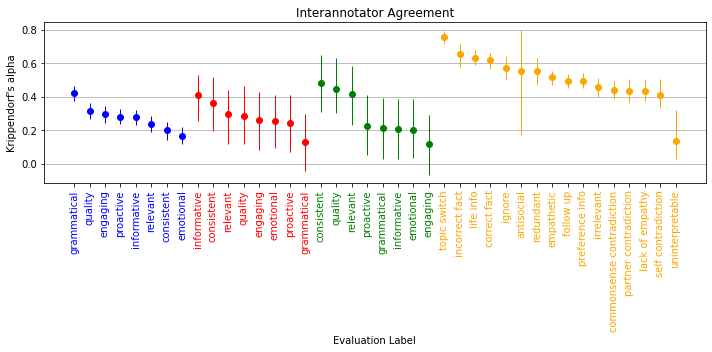

In [502]:
# Build the plot
plt.rcParams["figure.figsize"] = (10,5)

fig, ax = plt.subplots()

def plot_by_category(ax, df, category, color, xaxis_start):
    extracted = df[df["category"] == category]
    lower_bound = extracted["Krippendorff's alpha"] - extracted["CI low"]
    upper_bound = extracted["CI high"] - extracted["Krippendorff's alpha"]
    xaxis_end = xaxis_start + len(extracted)
    ax.errorbar(np.arange(xaxis_start, xaxis_end),
                extracted["Krippendorff's alpha"],
                yerr=[lower_bound, upper_bound],
                fmt='o',
                elinewidth=1,
                color=color)
    return xaxis_end

likert_turn_color = "blue"
likert_dialogue_color = "red"
comparative_color = "green"
behavior_color = "orange"

likert_dialogue_start = plot_by_category(ax, agreements, "likert turn", likert_turn_color, 0)
comparative_start = plot_by_category(ax, agreements, "likert dialogue", likert_dialogue_color, likert_dialogue_start)
behavior_start = plot_by_category(ax, agreements, "comparative", comparative_color, comparative_start)
misc_start = plot_by_category(ax, agreements, "behavior", behavior_color, behavior_start)

category_range = {likert_dialogue_start: likert_turn_color, comparative_start: likert_dialogue_color, behavior_start: comparative_color, misc_start: behavior_color}
xaxis_colors = {}
prev_idx = 0
for idx, color in category_range.items():
    for i in range(prev_idx, idx):
        xaxis_colors[i] = color
    prev_idx = idx

ax.set_ylabel("Krippendorf's alpha")
xpos = np.arange(len(agreements))
ax.set_xlabel("Evaluation Label")
ax.set_xticks(xpos)
ax.set_xticklabels(agreements["label"], rotation=90)
for tickloc, ticklabel in zip(plt.gca().get_xticks(), plt.gca().get_xticklabels()):
    ticklabel.set_color(xaxis_colors[tickloc])
ax.set_title('Interannotator Agreement')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
# plt.savefig('bar_plot_with_error_bars.png')
plt.show()

In [503]:
all_agreements = across_evaluations(
    [
        e.annotation_dataframe() for e in
        (data.student_evaluation, data.mturk_evaluation, data.surge_evaluation)
    ],
    agreement_dataframe,
    load='results/evaluation_agreements.csv'
)
all_agreements = prettify(all_agreements, float_prec=3, sort_by=["round", "category", "Krippendorff's alpha"], col_types={"n": int, "n.1": int}, to_csv='results/paper/all_agreements.csv', index=False)
all_agreements

,round,category,label,Krippendorff's alpha,CI low,CI high,n,Fleiss' kappa,CI low.1,CI high.1,n.1
92,2,likert turn,grammatical,0.419,0.372,0.464,1634,0.296,0.259,0.333,1634
95,2,likert turn,quality,0.312,0.267,0.357,1634,0.092,0.061,0.122,1634
91,2,likert turn,engaging,0.295,0.246,0.344,1634,0.123,0.092,0.153,1634
94,2,likert turn,proactive,0.279,0.232,0.327,1634,0.098,0.071,0.125,1634
93,2,likert turn,informative,0.278,0.233,0.321,1634,0.092,0.065,0.123,1634
...,...,...,...,...,...,...,...,...,...,...,...
6,0,comparative,informative,0.361,-0.193,0.839,12,0.333,-0.175,0.832,12
9,0,comparative,relevant,0.361,-0.178,0.839,12,0.333,-0.244,0.832,12
3,0,comparative,emotional,0.216,-0.315,0.799,12,0.127,-0.274,0.678,12
1,0,behavior,uninterpretable,0.322,NaN,NaN,152,0.320,NaN,NaN,152


# 7 Comprehensive Analysis

### Likert Dialogue

In [528]:
bots = ['Blender2', 'Emora', 'BartFidRAG', 'RerankBlender']
# https://blog.finxter.com/how-to-plot-matplotlibs-color-palette-and-choose-your-plot-color/
graphing_bot_colors = {
    'blender2_3B': 'purple',
    'bart_fid_rag_bcb': 'royalblue',
    'emora': 'turquoise',
    'rerank_blender': 'green'
}
bot_transformer = {
    'blender2_3B': 'Blender2',
    'emora': 'Emora',
    'rerank_blender': 'Blender-Decode',
    'bart_fid_rag_bcb': 'BART-FiDRAG'
}
dimensions_transformer = {
    'consistent': 'CO',
    'emotional': 'EU',
    'engaging': 'EN',
    'grammatical': 'GR',
    'informative': 'IN',
    'proactive': 'PR',
    'quality': 'OQ',
    'relevant': 'RE'
}

In [529]:
def grouped_barplot(df, title, ylabel, xlabel, ylim, value_col='mean', rot=45, fig_size=(10,5)):

    plt.rcParams["figure.figsize"] = fig_size

    df['lower'] = df[value_col] - df["CI low"]
    cilow = df.pivot(index='label', columns='bot', values='lower')
    df['upper'] = df["CI high"] - df[value_col]
    cihigh = df.pivot(index='label', columns='bot', values='upper')

    err = []
    for col in cilow:
        err.append([cilow[col].values, cihigh[col].values])

    df0 = df.pivot(index='label', columns='bot', values=value_col)
    ax = df0.plot(
        kind='bar',
        ylim=ylim,
        title=title,
        rot=rot,
        yerr=err,
        color=[graphing_bot_colors[bot] for bot in df0.columns]
    )
    ax.legend(
        [bot_transformer[bot] for bot in df0.columns],
        ncol=2
    )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_xticklabels([dimensions_transformer[d] if d in dimensions_transformer else behaviors_transformer[d] for d in df0.index])

In [505]:
def evaluate_likert_ratings(annotations, category, load=None, reload=None):
    if load:
        return pd.read_csv(load)
    single_annotated = get_singly_annotated(annotations)
    likert_annotations = single_annotated.xs(category, level=sym.category)
    label_groups = likert_annotations.groupby(level=[sym.bot, sym.label])
    means = label_groups.apply(mean_and_ci)
    if reload:
        means.to_csv(reload)
    return means

In [506]:
surge_likert_dialogue_ratings = evaluate_likert_ratings(
    surge_annotations, category.likert_dialogue,
    load='results/surge_likert_dialogue_ratings.csv'
)
sldr = prettify(surge_likert_dialogue_ratings, float_prec=3, col_types={"n": int}, sort_by=["bot", "mean"], to_csv="results/paper/surge_likert_dialogue_ratings.csv", index=False)
sldr

,bot,label,mean,CI low,CI high,n
28,rerank_blender,informative,3.94,3.751,4.129,100
26,rerank_blender,engaging,3.87,3.662,4.078,100
29,rerank_blender,proactive,3.82,3.616,4.024,100
25,rerank_blender,emotional,3.81,3.601,4.019,100
24,rerank_blender,consistent,3.67,3.432,3.908,100
31,rerank_blender,relevant,3.60,3.387,3.813,100
27,rerank_blender,grammatical,3.47,3.251,3.689,100
30,rerank_blender,quality,3.23,3.031,3.429,100
19,emora,grammatical,4.02,3.871,4.169,100
21,emora,proactive,3.94,3.745,4.135,100


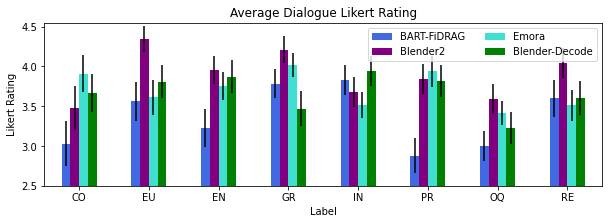

In [533]:
grouped_barplot(sldr, title="Average Dialogue Likert Rating", ylabel="Likert Rating", xlabel='Label', ylim=(2.5,4.55), rot=0, fig_size=(10,3))

### Likert Turn

In [509]:
surge_likert_turn_ratings = evaluate_likert_ratings(
    surge_annotations, category.likert_turn,
    load='results/surge_likert_turn_ratings.csv'
)
sltr = prettify(surge_likert_turn_ratings, float_prec=3, col_types={"n": int}, sort_by=["bot", "mean"], to_csv="results/paper/surge_likert_turn_ratings.csv", index=False)
sltr

,bot,label,mean,CI low,CI high,n
25,rerank_blender,emotional,4.213,4.160,4.265,1500
24,rerank_blender,consistent,4.034,3.972,4.096,1500
27,rerank_blender,grammatical,4.000,3.946,4.054,1500
26,rerank_blender,engaging,3.823,3.762,3.885,1500
31,rerank_blender,relevant,3.741,3.675,3.806,1500
28,rerank_blender,informative,3.728,3.673,3.783,1500
29,rerank_blender,proactive,3.644,3.582,3.706,1500
30,rerank_blender,quality,3.318,3.258,3.378,1500
19,emora,grammatical,4.533,4.499,4.567,1522
16,emora,consistent,4.140,4.081,4.199,1522


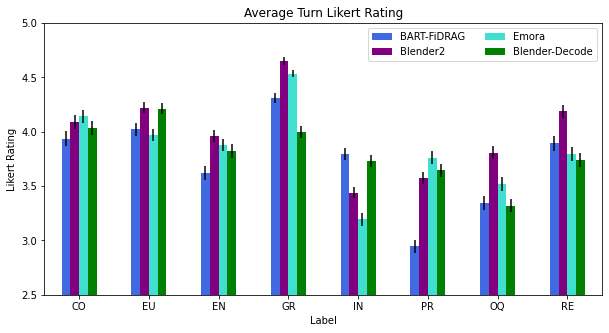

In [525]:
grouped_barplot(sltr, title="Average Turn Likert Rating", ylabel="Likert Rating", xlabel='Label', ylim=(2.5,5.0), rot=0)

### Comparative

In [511]:
comparison_df = evaluate_comparisons(
    surge_annotations_comparative,
    reload='results/surge_comparisons.csv'
)
comparison_df

lose    CI low   CI high      n  \
bot              bot comp label                                              
bart_fid_rag_bcb others   consistent   0.613861  0.516402  0.702977  101.0   
                          emotional    0.574257  0.476850  0.666223  101.0   
                          engaging     0.643564  0.546475  0.730133  101.0   
                          grammatical  0.445545  0.352380  0.542700  101.0   
                          informative  0.445545  0.352380  0.542700  101.0   
...                                         ...       ...       ...    ...   
rerank_blender   emora    grammatical  0.363636  0.221872  0.533838   33.0   
                          informative  0.303030  0.173755  0.473381   33.0   
                          proactive    0.424242  0.272356  0.591927   33.0   
                          quality      0.484848  0.325040  0.647816   33.0   
                          relevant     0.454545  0.298429  0.620141   33.0   

                                            tie        CI low   CI high  \
bot              bot comp label                                           
bart_fid_rag_bcb others   consistent   0.000000  3.469447e-18  0.036641   
                          emotional    0.059406  2.750813e-02  0.123591   
                          engaging     0.009901  1.749911e-03  0.053967   
                          grammatical  0.148515  9.211601e-02  0.230671   
                          informative  0.000000  3.469447e-18  0.036641   
...                                         ...           ...       ...   
rerank_blender   emora    grammatical  0.121212  4.816161e-02  0.273255   
                          informative  0.000000  0.000000e+00  0.104270   
                          proactive    0.000000  0.000000e+00  0.104270   
                          quality      0.000000  0.000000e+00  0.104270   
                          relevant     0.090909  3.140394e-02  0.235726   

                                           n       win    CI low   CI high  \
bot              bot comp label                                              
bart_fid_rag_bcb others   consistent   101.0  0.386139  0.297023  0.483598   
                          emotional    101.0  0.366337  0.278879  0.463590   
                          engaging     101.0  0.346535  0.260895  0.443420   
                          grammatical  101.0  0.405941  0.315324  0.503450   
                          informative  101.0  0.554455  0.457300  0.647620   
...                                      ...       ...       ...       ...   
rerank_blender   emora    grammatical   33.0  0.515152  0.352184  0.674960   
                          informative   33.0  0.696970  0.526619  0.826245   
                          proactive     33.0  0.575758  0.408073  0.727644   
                          quality       33.0  0.515152  0.352184  0.674960   
                          relevant      33.0  0.454545  0.298429  0.620141   

                                           n  
bot              bot comp label               
bart_fid_rag_bcb others   consistent   101.0  
                          emotional    101.0  
                          engaging     101.0  
                          grammatical  101.0  
                          informative  101.0  
...                                      ...  
rerank_blender   emora    grammatical   33.0  
                          informative   33.0  
                          proactive     33.0  
                          quality       33.0  
                          relevant      33.0  

[128 rows x 12 columns]

In [512]:
# each bot is a dataframe
botvothers = comparison_df[comparison_df.index.get_level_values('bot comp') == 'others'][['win', 'tie', 'lose']]
print(comparison_df.columns)
botvothers['CI low'] = comparison_df.iloc[:, 9]
botvothers['CI high'] = comparison_df.iloc[:, 10]
botvothers.reset_index(level=['bot comp'], inplace=True)
botvothers.drop('bot comp', inplace=True, axis='columns')
toplot = botvothers.reorder_levels(['label', 'bot']).sort_index()
toplot

Index(['lose', 'CI low', 'CI high', 'n', 'tie', 'CI low', 'CI high', 'n',
       'win', 'CI low', 'CI high', 'n'],
      dtype='object')


win       tie      lose    CI low   CI high
label       bot                                                               
consistent  bart_fid_rag_bcb  0.386139  0.000000  0.613861  0.297023  0.483598
            blender2_3B       0.372549  0.009804  0.617647  0.284950  0.469400
            emora             0.683168  0.009901  0.306931  0.587149  0.765765
            rerank_blender    0.520000  0.020000  0.460000  0.423166  0.615354
emotional   bart_fid_rag_bcb  0.366337  0.059406  0.574257  0.278879  0.463590
            blender2_3B       0.460784  0.068627  0.470588  0.367235  0.557180
            emora             0.524752  0.079208  0.396040  0.428250  0.619441
            rerank_blender    0.520000  0.050000  0.430000  0.423166  0.615354
engaging    bart_fid_rag_bcb  0.346535  0.009901  0.643564  0.260895  0.443420
            blender2_3B       0.470588  0.019608  0.509804  0.376559  0.566752
            emora             0.544554  0.000000  0.455446  0.447580  0.638264
            rerank_blender    0.640000  0.030000  0.330000  0.542354  0.727288
grammatical bart_fid_rag_bcb  0.405941  0.148515  0.445545  0.315324  0.503450
            blender2_3B       0.500000  0.166667  0.333333  0.404744  0.595256
            emora             0.396040  0.118812  0.485149  0.306154  0.493543
            rerank_blender    0.420000  0.150000  0.430000  0.327984  0.517935
informative bart_fid_rag_bcb  0.554455  0.000000  0.445545  0.457300  0.647620
            blender2_3B       0.303922  0.009804  0.686275  0.223124  0.398952
            emora             0.435644  0.009901  0.554455  0.343060  0.532944
            rerank_blender    0.650000  0.000000  0.350000  0.552544  0.736358
proactive   bart_fid_rag_bcb  0.267327  0.019802  0.712871  0.190710  0.360994
            blender2_3B       0.470588  0.000000  0.529412  0.376559  0.566752
            emora             0.554455  0.009901  0.435644  0.457300  0.647620
            rerank_blender    0.650000  0.010000  0.340000  0.552544  0.736358
quality     bart_fid_rag_bcb  0.435644  0.009901  0.554455  0.343060  0.532944
            blender2_3B       0.450980  0.009804  0.539216  0.357946  0.547573
            emora             0.534653  0.009901  0.455446  0.437897  0.628871
            rerank_blender    0.560000  0.010000  0.430000  0.462281  0.653280
relevant    bart_fid_rag_bcb  0.396040  0.009901  0.594059  0.306154  0.493543
            blender2_3B       0.480392  0.000000  0.519608  0.385919  0.576289
            emora             0.564356  0.029703  0.405941  0.467056  0.656940
            rerank_blender    0.520000  0.030000  0.450000  0.423166  0.615354

In [526]:
from matplotlib.text import Text

def plot_comparative(df0, title, value_col, fig_size):
    # https://stackoverflow.com/questions/59922701/pandas-how-can-i-group-a-stacked-bar-chart
    plt.rcParams["figure.figsize"] = fig_size

    df0['lower'] = df0[value_col] - df0["CI low"]
    df0['upper'] = df0["CI high"] - df0[value_col]

    errLow = df0[['lower']].reset_index(['bot', 'label']).pivot(index='label', columns='bot', values='lower')
    errHi = df0[['upper']].reset_index(['bot', 'label']).pivot(index='label', columns='bot', values='upper')

    # 4 x 2 x 8 (bots x low, hi x labels)
    err = []
    for col in errLow:
        err.append([errLow[col].values, errHi[col].values])

    df0 = df0.unstack(level=-1)
    fig, ax = plt.subplots()

    groups = []
    for i in df0.columns:
        if i[1] not in groups:
            groups.append(i[1])

    (df0['win']+df0['tie']+df0['lose']).plot(kind='bar', color=[graphing_bot_colors[i] for i in groups], alpha=0.2, rot=0, ax=ax)
    (df0['win']+df0['tie']).plot(kind='bar', color=[graphing_bot_colors[i] for i in groups], alpha=0.4, rot=0, ax=ax)
    df0['win'].plot(kind='bar', color=[graphing_bot_colors[i] for i in groups], rot=0, ax=ax, yerr=err)

    h, l = ax.get_legend_handles_labels()
    markers = {}
    for h, l, (wtl, bot) in zip(h, l, df0.columns):
        markers.setdefault(bot, []).append((h,l))
    wtl_dummies = [plt.plot([],marker="", ls="")[0]]*4
    bot_dummies = [plt.plot([],marker="", ls="")[0]]*4
    handles = wtl_dummies
    labels = ["", "Lose:", "Tie:", "Win:"]
    for i, (bot, symbols) in enumerate(markers.items()):
        handles.append(bot_dummies[i])
        labels.append(bot_transformer[bot])
        handles.extend([s[0] for s in symbols])
        labels.extend(["" for s in symbols])
    leg = plt.legend(handles, labels, ncol=5, loc='upper right', bbox_to_anchor=(0.67, -0.35), labelspacing=0.25)
    for i, vpack in enumerate(leg._legend_handle_box.get_children()):
        if i == 0: # row titles
            for hpack in vpack.get_children():
                hpack.get_children()[0].set_width(0)
        else:
            for j, hpack in enumerate(vpack.get_children()):
                if j > 0: # bot win/tie/lose markers
                    hpack.get_children()[0].get_children()[0].set_width(50)
                else: # column titles
                    hpack.get_children()[0].set_width(0)
    ax.set_title(title)
    ax.set_ylabel('Proportion')
    ax.set_xlabel('Label')
    ax.set_xticklabels([dimensions_transformer[d] for d in df0.index])

    plt.tight_layout()
    plt.show()
    return df0

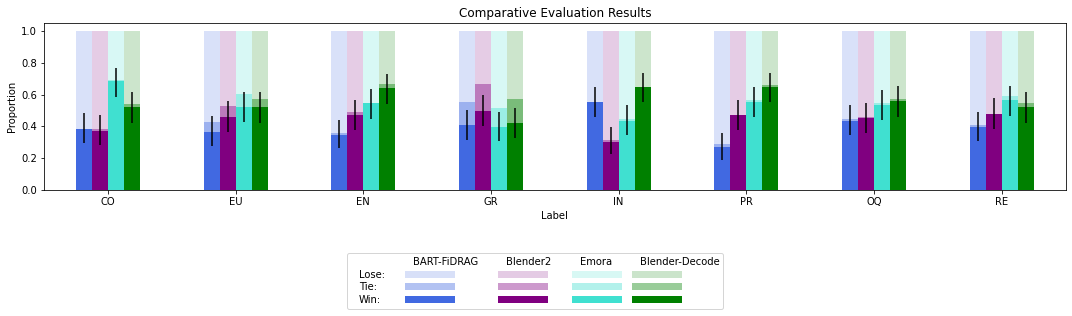

In [527]:
df = plot_comparative(toplot, 'Comparative Evaluation Results', 'win', (15,5))

### Behaviors

In [515]:
def evaluate_behavior_rates(annotations, load=None, reload=None):
    if load:
        return pd.read_csv(load)
    single_annotated = get_singly_annotated(annotations)
    behavior_annotations = single_annotated.xs(category.behavior, level=sym.category)
    label_groups = behavior_annotations.groupby(level=[sym.bot, sym.label])
    means = label_groups.apply(prop_and_ci)
    if reload:
        means.to_csv(reload)
    return means

In [516]:
surge_behavior_rates = evaluate_behavior_rates(
    surge_annotations,
    load='results/surge_behavior_rates.csv'
)
sbr = prettify(surge_behavior_rates,  float_prec=3, col_types={"n": int}, sort_by=["bot", "proportion"], to_csv="results/paper/surge_behavior_rates.csv", index=False)
sbr

,bot,label,proportion,CI low,CI high,n
51,rerank_blender,empathetic,0.435,0.410,0.460,1500
52,rerank_blender,follow up,0.419,0.395,0.444,1500
59,rerank_blender,preference info,0.309,0.286,0.333,1500
62,rerank_blender,topic switch,0.253,0.231,0.275,1500
57,rerank_blender,life info,0.248,0.227,0.270,1500
...,...,...,...,...,...,...
7,bart_fid_rag_bcb,irrelevant,0.110,0.095,0.127,1512
10,bart_fid_rag_bcb,partner contradiction,0.071,0.059,0.085,1512
12,bart_fid_rag_bcb,redundant,0.054,0.044,0.067,1512
15,bart_fid_rag_bcb,uninterpretable,0.013,0.008,0.020,1512


/var/folders/zw/yjw73zhj0_zfrnypnl9hgppm0000gn/T/ipykernel_2712/2133406498.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lower'] = df[value_col] - df["CI low"]
/var/folders/zw/yjw73zhj0_zfrnypnl9hgppm0000gn/T/ipykernel_2712/2133406498.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['upper'] = df["CI high"] - df[value_col]
/var/folders/zw/yjw73zhj0_zfrnypnl9hgppm0000gn/T/ipykernel_2712/2133406498.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

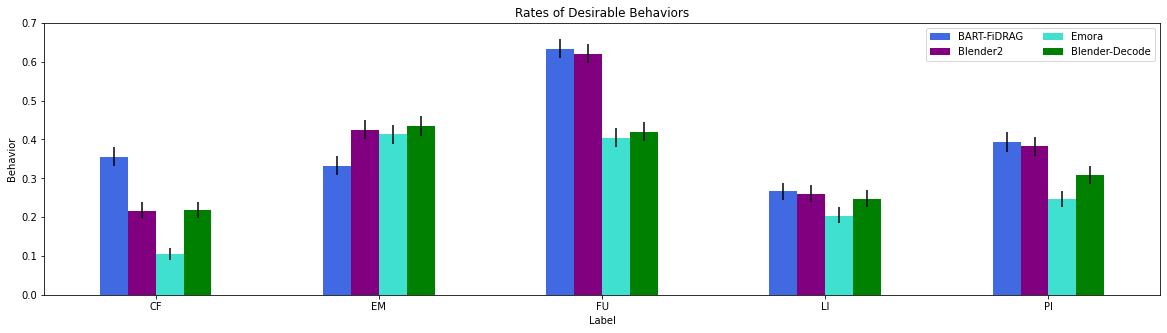

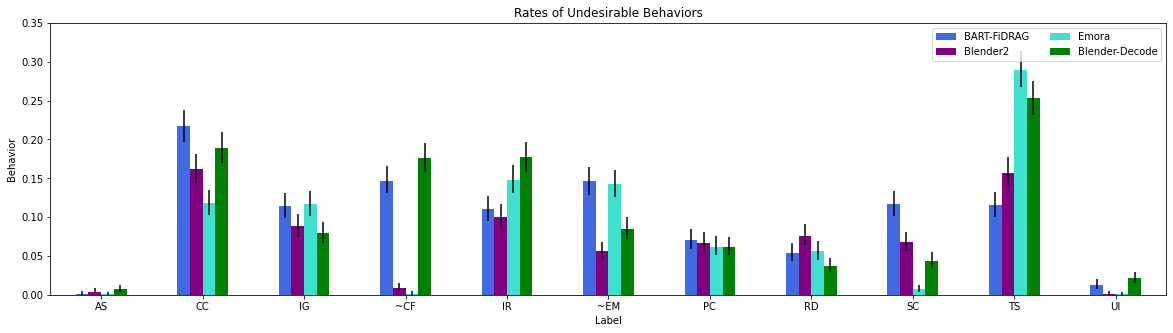

In [531]:
behaviors_transformer = {
    'correct fact': 'CF',
    'empathetic': 'EM',
    'follow up': 'FU',
    'life info': 'LI',
    'preference info': 'PI',
    'uninterpretable': 'UI',
    'antisocial': 'AS',
    'commonsense contradiction': 'CC',
    'ignore': 'IG',
    'incorrect fact': '~CF',
    'irrelevant': 'IR',
    'lack of empathy': '~EM',
    'partner contradiction': 'PC',
    'redundant': 'RD',
    'self contradiction': 'SC',
    'topic switch': 'TS'
}

to_maximize = {'correct fact', 'empathetic', 'follow up', 'life info', 'preference info'}
maximize = sbr[sbr['label'].isin(to_maximize)]
grouped_barplot(maximize, title="Rates of Desirable Behaviors", ylabel="Behavior", xlabel='Label', ylim=(0,0.7), value_col="proportion", rot=0, fig_size=(20,5))

to_minimize = {'uninterpretable', 'antisocial', 'commonsense contradiction', 'ignore', 'incorrect fact', 'irrelevant', 'lack of empathy', 'partner contradiction', 'redundant', 'self contradiction', 'topic switch'}
minimize = sbr[sbr['label'].isin(to_minimize)]
grouped_barplot(minimize, title="Rates of Undesirable Behaviors", ylabel="Behavior", xlabel='Label', ylim=(0,0.35), value_col="proportion", rot=0, fig_size=(20,5))

# 8 Evaluation Metric Assessment

### Metric Sensitivity

In [518]:
from itertools import combinations
from scipy.stats import ttest_ind

def t_tests(df: pd.DataFrame):
    """
    :param df: (bot, data point) x 1 -> score
    :return: p values of test on each bot pair (pd.Series)
    """
    bots = set(df.index.get_level_values(0))
    bot_pairs = list(combinations(bots, 2))
    result = {}
    for ba, bb in bot_pairs:
        a = df.xs(ba).to_numpy().squeeze()
        b = df.xs(bb).to_numpy().squeeze()
        t, p = ttest_ind(a, b)
        result[(ba, bb)] = p
    result_series = pd.Series(result.values(), result)
    return result_series

get_singly_annotated(surge_annotations).xs(
    category.likert_turn,
    level=sym.category
).groupby(
    sym.label
).apply(
    t_tests
)

blender2_3B                                          emora  \
                    emora rerank_blender bart_fid_rag_bcb rerank_blender   
label                                                                      
consistent   3.202258e-01   3.974450e-01     1.641548e-03   6.150188e-02   
emotional    1.458590e-12   4.873241e-01     8.042664e-10   3.089800e-10   
engaging     3.388186e-02   5.737756e-05     1.548385e-13   4.450630e-02   
grammatical  1.259973e-05   8.340986e-83     9.079602e-30   5.853912e-61   
informative  2.358728e-10   7.321290e-15     2.114359e-20   1.607407e-40   
proactive    1.599599e-05   8.555421e-02     8.080369e-51   1.403651e-02   
quality      4.717359e-08   4.606636e-27     2.810324e-22   1.950697e-07   
relevant     8.285739e-17   7.896203e-23     2.426902e-09   1.561723e-01   

                               rerank_blender  
            bart_fid_rag_bcb bart_fid_rag_bcb  
label                                          
consistent      3.082214e-05     1.828072e-02  
emotional       5.902241e-01     6.072199e-08  
engaging        4.034663e-08     5.716060e-04  
grammatical     1.514652e-15     1.987924e-16  
informative     9.844346e-49     1.410483e-01  
proactive       2.465946e-78     7.902666e-58  
quality         9.602646e-06     5.985842e-01  
relevant        3.532057e-02     4.657267e-04

### Predictive Validity

In [519]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

def regressions(df, quality_column_name=None):
    """
    :param df: dialogue x (*features, quality) -> value
    :return: *(coef, low, high), mcfadden r^2
    """
    if not quality_column_name:
        quality_column_name = df.columns[-1]
    qualities = df[quality_column_name]
    features = [f for f in df.columns if f != quality_column_name]
    model = OrderedModel(qualities, df[features], distr='logit')
    results = model.fit()
    coefs = {f: results.params[f] for f in features}
    prsqrd = results.prsquared
    result = {**coefs, stat.mcfad_r2: prsqrd}
    return pd.Series(result.values(), result)

def dialogue_metrics(ev):
    df: pd.DataFrame = ev.annotation_dataframe()
    df = get_singly_annotated(df, seed=123)
    reindexed = df.reset_index()
    items = reindexed[sym.item]
    dialogues = [e[0] if isinstance(e, tuple) else e for e in items]
    reindexed['dialogue'] = dialogues
    reindexed.set_index(
        [sym.bot, sym.category, sym.label, 'dialogue', sym.item],
        inplace=True, verify_integrity=True
    )
    ld = reindexed.xs(category.likert_dialogue, level=sym.category)
    ld = ld.droplevel(sym.bot).droplevel(sym.item)
    ld.columns = ['score']
    ldq = ld.xs(scale.quality, level=sym.label)
    ldq.columns = ['quality']

    lt = reindexed.xs(category.likert_turn, level=sym.category)
    lt = lt.groupby([sym.label, 'dialogue']).mean()
    lt.columns = ['score']
    ltq = lt.xs(scale.quality, level=sym.label)
    ltq.columns = ['quality']

    be = reindexed.xs(category.behavior, level=sym.category)
    be = be.groupby([sym.label, 'dialogue']).mean()
    be.columns = ['score']

    ds = pd.concat(
        [lt, be, ld],
        keys=[category.likert_turn, category.behavior, category.likert_dialogue],
        names=[sym.category, sym.label, 'dialogue']
    )
    likert_dialogue_quality_features = ds.join(ldq, on='dialogue')
    likert_turn_quality_features = ds.join(ltq, on='dialogue')
    return likert_dialogue_quality_features, likert_turn_quality_features

@to_file
def dialogue_quality_regressions(ev):
    ldq, ltq = dialogue_metrics(ev)
    groups = ldq.groupby(
        [sym.category, sym.label]
    )
    result = groups.apply(regressions)
    return result

"""

"""

dialogue_quality_regressions(
    data.surge_evaluation,
    load='results/dialogue_quality_regressions.csv'
)

,category,label,score,McFadden's pseudo-R-squared
0,likert turn,consistent,0.437186,0.008301
1,likert turn,emotional,0.459415,0.010492
2,likert turn,engaging,0.364656,0.009000
3,likert turn,grammatical,-0.038475,0.000054
4,likert turn,informative,-0.024559,0.000033
5,likert turn,proactive,0.418151,0.011262
6,likert turn,quality,0.451505,0.009052
7,likert turn,relevant,0.411045,0.010554
8,behavior,antisocial,6.022125,0.001190
9,behavior,commonsense contradiction,-3.765228,0.024278


### Agreement Between Static and Interactive Evaluators